In [39]:
import torch
from torch.autograd.grad_mode import F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from sklearn import mixture
import matplotlib.pyplot as plt

from torch_geometric.nn import VGAE

import scipy.sparse as sp
import numpy as np
import networkx as nx

In [40]:
import torch
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
from torch_geometric.nn.inits import reset
EPS = 1e-15
MAX_LOGSTD = 1

In [41]:
class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""
    def forward(self, z, edge_index, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value


    def forward_all(self, z, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj

In [42]:
def weights_init(m, mean = 0, sd = 0.01):
    """initialize parameters"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        import pdb; pdb.set_trace()
        torch.nn.init.normal_(m.weight, mean, sd)
        #torch.nn.init.zeros_(m.weight)
        torch.nn.init.zeros_(m.bias) 

class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (Module): The encoder module.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, decoder=None):
        super(GAE, self).__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        #self.apply(weights_init)
        GAE.reset_parameters(self)
    
    def reset_parameters(self):
        reset(self.encoder)
        reset(self.decoder)

    def encode(self, *args, **kwargs):
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)


    def decode(self, *args, **kwargs):
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)


    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to train against.
            neg_edge_index (LongTensor, optional): The negative edges to train
                against. If not given, uses negative sampling to calculate
                negative edges. (default: :obj:`None`)
        """

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).mean()

        # Do not include self-loops in negative samples
        pos_edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index, _ = add_self_loops(pos_edge_index)
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()

        return pos_loss + neg_loss  
    
    def test(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        scores.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to evaluate
                against.
            neg_edge_index (LongTensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import roc_auc_score, average_precision_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)
        
        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)

In [43]:
class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (Module): The encoder module to compute :math:`\mu` and
            :math:`\log\sigma^2`.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, decoder=None):
        super(VGAE, self).__init__(encoder, decoder)

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    #z = model.encode(train_data.x, train_data.edge_index)
    def encode(self, *args, **kwargs):
        """"""
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z

    def kl_loss(self, mu=None, logstd=None):
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (Tensor, optional): The latent space for :math:`\mu`. If set to
                :obj:`None`, uses the last computation of :math:`mu`.
                (default: :obj:`None`)
            logstd (Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`.(default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))

In [44]:
class SimuData():
    """Simulate graph data"""
    def __init__(self, n_node=10, n_graph=30):
        self.n_node = n_node
        self.n_graph = n_graph

    def simu_adj_wgh1(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.zeros(self.n_node, self.n_node)

            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W = torch.rand(5,5)

            ## symmetric
            i, j = torch.triu_indices(5, 5)
            W[i, j] = W.T[i, j]

            A[:5,:5] = W
            adj_list.append(A)  

        return adj_list
    
    def simu_adj_wgh2(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.zeros(self.n_node, self.n_node)

            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W = torch.zeros(5, 5)
            W[:,1] =1
            W[1,:] =1
            
            ## symmetric
            i, j = torch.triu_indices(5, 5)
            W[i, j] = W.T[i, j]

            A[:5,:5] = W
            adj_list.append(A)  

        return adj_list

    def simu_adj_wgh3(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.rand(self.n_node, self.n_node)

            ## symmetric
            i, j = torch.triu_indices(self.n_node, self.n_node)
            A[i, j] = A.T[i, j]

            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W = torch.zeros(5, 5)
            W = W + torch.eye(5)
            A[:5,:5] = W
            adj_list.append(A)  
        
        return adj_list
    
    def simu_adj_wgh4(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.zeros(self.n_node, self.n_node)
            
            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W1 = torch.rand(5,5)
            # last five nodes weights: uniform(0,1)A[:5,:5] = W
            W2 = torch.rand(5,5)
            
            ## symmetric
            i, j = torch.triu_indices(5, 5)
            W1[i, j] = W1.T[i, j]
            W1[W1>0.2] = 1
            W1[W1<0.2] = 0
            W2[i, j] = W2.T[i, j]
            W2[W2>0.2] = 1
            W2[W2<0.2] = 0           
            A[:5,:5] = W1
            A[-5:,-5:] = W2
            
            adj_list.append(A)  

        return adj_list
    
    def simu_adj_diag(self):
        adj_list = []

        for i in range(self.n_graph):
            A = torch.eye(self.n_node)
            adj_list.append(A)  

        return adj_list

    def simu_adj_m(self, p =0.2):
        """generating adjacency matrix"""
        adj_wgh = self.simu_adj_wgh4()
        #adj_wgh = self.simu_adj_diag()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>p] = 1
            adj[adj<p] = 0
            
            adj_m_list.append(adj)    
        
        return adj_m_list

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.simu_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            pos_edge_index_A = edge_index_A[:,edge_index_A[0]<edge_index_A[1]]
            x = self.get_x_feature()
            data = Data(x=x, adj = adj, edge_index=edge_index_A, pos_edge_label_index=pos_edge_index_A)
            dataset.append(data)

        return dataset

    def get_x_feature(self):
        x = torch.arange(self.n_node)
        x_onehot = torch.eye(self.n_node)[x,:] 

        return torch.FloatTensor(x_onehot)
        #x = torch.FloatTensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
        #x = x.reshape(10,1).expand( 10,10  )
        #return x


In [45]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels) 
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


In [ ]:
simu_graph = SimuData(n_graph=300)
dataset = simu_graph.graph_dataset()
n_node = simu_graph.n_node

out_channels = 2
num_features = n_node

model = VGAE(Encoder(num_features, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 2000

for epoch in range(epochs):
    loss_total = 0
    optimizer.zero_grad()

    for i in range(len(dataset)):
        train_data = dataset[i]
        z = model.encode(train_data.x, train_data.edge_index)
        loss = model.recon_loss(z, train_data.pos_edge_label_index)
        loss = loss + 0.1*(1 /num_features) * model.kl_loss()
        loss_total += loss
    
    loss_avg = loss_total/len(dataset)
    loss_avg.backward()
    optimizer.step()
    if (epoch % 100) == 0:
        print(epoch, loss_avg.item())
    
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp



In [ ]:
simu_graph = SimuData(n_graph=30)
dataset = simu_graph.graph_dataset()
n_node = simu_graph.n_node

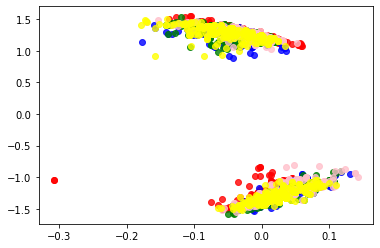

In [54]:
colors = ['red', 'blue','green', 'pink', 'yellow',
          'red', 'blue','green', 'pink', 'yellow']
mu_list = []
logstd_list = []
for i in range(len(dataset)):
    
    train_data = dataset[i]
    mu, logstd = model.encoder(train_data.x, train_data.edge_index)
    mu_list.append(np.asarray(mu.detach()))
    logstd_list.append(np.asarray(logstd.detach()))

# 30mu Encoder cached = TRUE
# 1mu model.encoder cached = TRUE
# 30mu model.encoder cached = FALSE
plt.figure()
for node_i in range(n_node):
    
    node_mu = np.empty((0, 2))
    for graph_i in range(len(mu_list)):
    
        node_mu = np.vstack((node_mu, mu_list[graph_i][node_i, :]))
    
    plt.scatter(node_mu[:,0],node_mu[:,1], c=colors[node_i],alpha=0.8)

plt.show()

In [50]:
mu

tensor([[ 0.9074, -1.0027],
        [ 0.8774, -0.9031],
        [ 0.9323, -1.1253],
        [ 0.7666, -0.7752],
        [ 0.8637, -0.9659],
        [-0.8093,  0.8751],
        [-0.9445,  0.9478],
        [-0.8093,  0.8751],
        [-0.6563,  0.7791],
        [-0.9445,  0.9478]], grad_fn=<AddBackward0>)

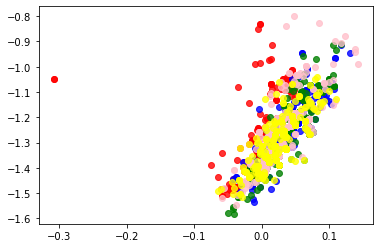

In [55]:
plt.figure()
for node_i in range(5):
    
    node_mu = np.empty((0, 2))
    for graph_i in range(len(mu_list)):
    
        node_mu = np.vstack((node_mu, mu_list[graph_i][node_i, :]))
    
    plt.scatter(node_mu[:,0],node_mu[:,1], c=colors[node_i],alpha=0.8)

plt.show()

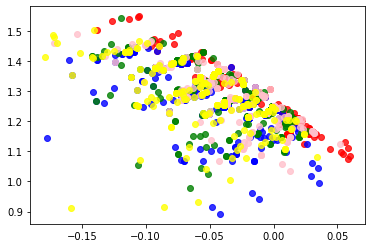

In [56]:
plt.figure()
for node_i in [5,6,7,8,9]:
    
    node_mu = np.empty((0, 2))
    for graph_i in range(len(mu_list)):
    
        node_mu = np.vstack((node_mu, mu_list[graph_i][node_i, :]))
    
    plt.scatter(node_mu[:,0],node_mu[:,1], c=colors[node_i],alpha=0.8)

plt.show()

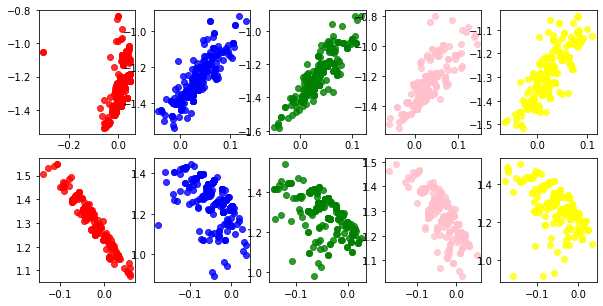

In [57]:
plt.subplots(5, 2, figsize=(10,5))
for node_i in range(n_node):
    plt.subplot(2, 5, node_i+1)
    node_mu = np.empty((0, 2))
    for graph_i in range(len(mu_list)):
    
        node_mu = np.vstack((node_mu, mu_list[graph_i][node_i, :]))
    
    plt.scatter(node_mu[:,0],node_mu[:,1], c=colors[node_i],alpha=0.8)

plt.show()


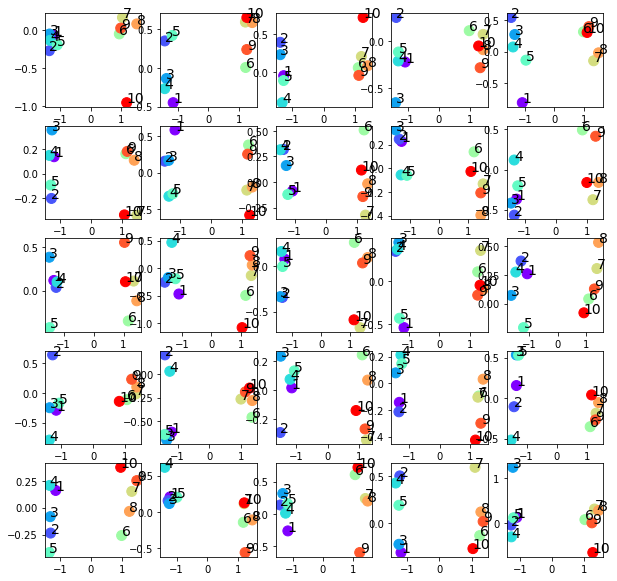

In [23]:
def plot_mu_graph(mu ):

    n_node = mu.shape[0]
    annotations = [str(i+1) for i in range(n_node)]
    colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
    plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)
    #import pdb; pdb.set_trace()

    for i, label in enumerate(annotations):
        plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

plt.subplots(10, 10, figsize=(10,10))
    
for graph_i in range(25): 
    plt.subplot(5, 5, graph_i+1) 
    plot_mu_graph(mu_list[graph_i])
#plt.show() 
plt.savefig('/Users/nat/Downloads/Yale/project/vgae/results/graph_embed.pdf')

In [ ]:
def dis_matrix(mu):

    n_node = mu.shape[0]
    dis_m = np.zeros((n_node, n_node))

    for i in range(n_node):
        for j in range(i+1, n_node):

            v1 = mu[i, :]
            v2 = mu[j,:]
            dis_m[i,j] = np.linalg.norm(v1-v2)
            dis_m[j,i] = dis_m[i,j]
    return dis_m

dis_first = []
dis_last = []
for graph_i in range(len(mu_list)):
    dis_m = dis_matrix(mu_list[graph_i])
    
    dis_avg_first = dis_m[:5,:5].sum()/(25-5)
    dis_avg_last = dis_m[:5,-5:].sum()/25
    dis_first.append(dis_avg_first)
    dis_last.append(dis_avg_last)

print("first:")
print(np.mean(dis_first))

print("last:")
print(np.mean(dis_last))

In [ ]:
index = np.triu_indices(10)
index = np.vstack((index[0], index[1]))
index.shape

In [ ]:
def sample_adj_mat(mu, logstd, edge_index, threshold=0.7):
    z = model.reparametrize(mu, logstd)
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))

    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    
    adj_mat[adj_mat < threshold] = 0 
    return adj_mat

fig, ax = plt.subplots(5, 5, figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(sample_adj_mat(mu_list[i], logstd_list[i],edge_index), cmap="Greys")


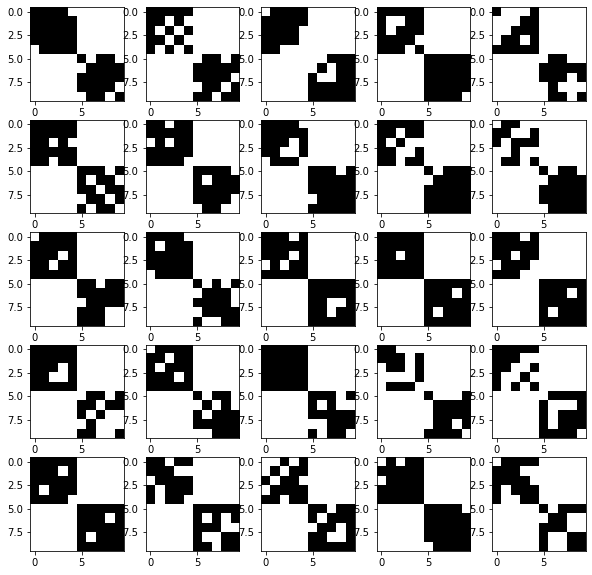

In [24]:
fig, ax = plt.subplots(5, 5, figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(dataset[i].adj, cmap="Greys")

In [ ]:
dir(model)